In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from histogrammi_3D import *
# tai from ... import *

In [2]:
@interact_manual

def dataoptions(
    tables = widgets.SelectMultiple(options= OptTables,value=['SensorData'],description='Db Tables: ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM {} WHERE timestamp >= {} and timestamp < {}".format(tables[0],start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM {} WHERE node_id={} and timestamp >= {} and timestamp < {}".format(tables[0],nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM {} WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(tables[0],nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        # Timestamp datetime muotoon
        
        try:
            df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
            
        except TypeError:
            df['timestamp'] = df['timestamp'].astype(str)
            df['timestamp'] = df['timestamp'].str.slice(2, -2)
            df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Db Tables: ', index=(3,), layout=Layout(margin='0px 0px 40px…

# Group kokonaismatka ja otetaan kesto jokaiselta ajokerralta

In [38]:
matka = df.groupby(['ajokerta'])['distance'].sum().values
kesto = df.groupby(['ajokerta'])['kesto'].unique().astype('int64').values
kesto = kesto.reshape((-1, 1))


# LinearRegressio malli + coefficient, intercept, slope

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(kesto, matka)

r_sq = model.score(kesto,matka)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
intercept: 5.633333333333329
print('slope:', model.coef_)


coefficient of determination: 0.0035069649494035016
intercept: 191.4824915496002
slope: [0.00372319]


# Ennustus + plot

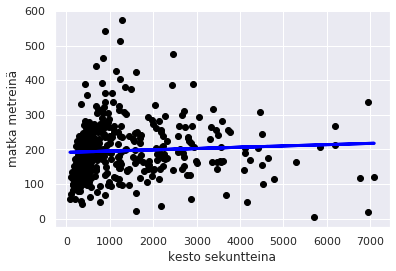

In [57]:
y_pred = model.predict(kesto)

plt.scatter(kesto, matka,  color='black')
plt.plot(kesto, y_pred, color='blue', linewidth=3)
plt.xlabel('kesto sekuntteina')
plt.ylabel('matka metreinä')

plt.show()

# Mikä on ennuste kauppareitin pituudelle, kun siihen kului aikaa 5 min 30 s?

In [58]:
y_pred = model.predict([[330]])
print(y_pred)

[192.71114455]
